# Fast inference for Hugging Face tasks models on CPU (for example: QA model)

- **Author**: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/)
- **Version & Date** : v1 (10/22/2021)
- **Blog post**: [NLP nas empresas | Técnicas para acelerar modelos de Deep Learning para inferência em produção](https://medium.com/@pierre_guillou/nlp-nas-empresas-t%C3%A9cnicas-para-acelerar-modelos-de-deep-learning-para-infer%C3%AAncia-em-produ%C3%A7%C3%A3o-884acbf49f20)
- **Other notebook** : [fast_inference_transformers_on_GPU.ipynb](https://github.com/piegu/language-models/blob/master/fast_inference_transformers_on_GPU.ipynb)


## Notebook overview

### Objective
The objective of this notebook is to help those who want to **accelerate inference time on CPU for tasks models of Hugging Face** (NER, QA, Classification...).

### Method for inference

source: https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615/2

- `model.eval()` will notify all your layers that you are in eval mode, that way, batchnorm or dropout layers will work in eval mode instead of training mode.
- `torch.no_grad()` impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script).

### References
- post blog from HF and Microsoft: [Accelerate your NLP pipelines using Hugging Face Transformers and ONNX Runtime](https://medium.com/microsoftazure/accelerate-your-nlp-pipelines-using-hugging-face-transformers-and-onnx-runtime-2443578f4333) (19/05/2020)

## System overview

In [1]:
import platform
platform.platform()

'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic'

### CPU

In [2]:
from psutil import *

In [3]:
cpu_count(),cpu_stats()

(2,
 scpustats(ctx_switches=695139, interrupts=346474, soft_interrupts=359163, syscalls=0))

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

In [5]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   47G   62G  43% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.9G     0  5.9G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   28K  6.4G   1% /var/colab
/dev/sda1        81G   51G   31G  63% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [6]:
virtual_memory()

svmem(total=13622198272, available=12802056192, percent=6.0, used=543846400, free=10809655296, active=1039499264, inactive=1529974784, buffers=125227008, cached=2143469568, shared=1171456, slab=192012288)

## Installation

In [7]:
%%capture
!pip install transformers

In [8]:
import transformers, torch, numpy as np

print("transformers:",transformers.__version__)
print("torch:",torch.__version__)
print("numpy:",np.__version__)

transformers: 4.11.3
torch: 1.9.0+cu111
numpy: 1.19.5


In [9]:
from time import perf_counter
def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

## QA model

Model at https://huggingface.co/pierreguillou/bert-base-cased-squad-v1.1-portuguese

In [10]:
model_checkpoint = "pierreguillou/bert-base-cased-squad-v1.1-portuguese"
# model_checkpoint = "pierreguillou/bert-large-cased-squad-v1.1-portuguese"

In [11]:
context = r"""
A pandemia de COVID-19, também conhecida como pandemia de coronavírus, é uma pandemia em curso de COVID-19, 
uma doença respiratória aguda causada pelo coronavírus da síndrome respiratória aguda grave 2 (SARS-CoV-2). 
A doença foi identificada pela primeira vez em Wuhan, na província de Hubei, República Popular da China, 
em 1 de dezembro de 2019, mas o primeiro caso foi reportado em 31 de dezembro do mesmo ano. 
Acredita-se que o vírus tenha uma origem zoonótica, porque os primeiros casos confirmados 
tinham principalmente ligações ao Mercado Atacadista de Frutos do Mar de Huanan, que também vendia animais vivos. 
Em 11 de março de 2020, a Organização Mundial da Saúde declarou o surto uma pandemia. Até 8 de fevereiro de 2021, 
pelo menos 105 743 102 casos da doença foram confirmados em pelo menos 191 países e territórios, 
com cerca de 2 308 943 mortes e 58 851 440 pessoas curadas.
"""

question = "Quando começou a pandemia de Covid-19 no mundo?"

## 1. Check the model

Before evaluating its inference time, let's check that our QA model is working well.

#### 1.1 Without pipeline

In [12]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model.eval();

Downloading:   0%|          | 0.00/494 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

In [13]:
# code source: https://huggingface.co/transformers/master/task_summary.html#extractive-question-answering

# tokenize inputs
inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")

# get outputs
outputs = model(**inputs)
answer_start_scores = outputs.start_logits
answer_end_scores = outputs.end_logits

# Get the most likely beginning of answer with the argmax of the score
answer_start = torch.argmax(answer_start_scores)
# Get the most likely end of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1

input_ids = inputs["input_ids"].tolist()[0]
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

# print answer
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Quando começou a pandemia de Covid-19 no mundo?
Answer: 1 de dezembro de 2019


That's the right answer!

#### 1.2 With pipeline

We can use Pipeline, too.

In [14]:
from transformers import pipeline

nlp = pipeline("question-answering", model=model_checkpoint)

In [15]:
# get result
result = nlp(question, context)

# print answer
print(f"Question: {question}")
print(f"Answer: {result['answer']} (score: {round(result['score'], 4)})")

Question: Quando começou a pandemia de Covid-19 no mundo?
Answer: 1 de dezembro de 2019 (score: 0.713)


That's the right answer!

## 2. Inference time | PyTorch model

### 2.1 PyTorch model (without pipeline)

In [16]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
model.eval();

#### 1. Tokenize the inputs

In [17]:
num=100

total = 0
for i in range(num):
  start = perf_counter()
  inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
  diff = perf_counter() - start
  total += diff

mean_tokenizer = round((total/num)*1000,2)
print(f'average time: {mean_tokenizer} ms')

average time: 0.73 ms


#### 2. Model on CPU

In [18]:
# put model and inputs to cpu
model = model.to('cpu')
inputs = inputs.to('cpu')

# get mean time
with torch.no_grad():
  mean_time_cpu = round(np.mean([timer(model,inputs.input_ids,inputs.token_type_ids,inputs.attention_mask) for _ in range(100)]),2)

print(f'average time: {mean_time_cpu} ms')

average time: 889.07 ms


Now, we can evaluate the time to get the answer.

In [19]:
# get outputs
with torch.no_grad():
  outputs = model(**inputs)

In [20]:
num = 100

total = 0
for i in range(num):
  start = perf_counter()
  answer_start_scores = outputs.start_logits
  answer_end_scores = outputs.end_logits

  # Get the most likely beginning of answer with the argmax of the score
  answer_start = torch.argmax(answer_start_scores)
  # Get the most likely end of answer with the argmax of the score
  answer_end = torch.argmax(answer_end_scores) + 1

  input_ids = inputs["input_ids"].tolist()[0]
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))
  diff = perf_counter() - start
  total += diff

mean_time_cpu_answer = round((total/num)*1000,2)
print(f'average time: {mean_time_cpu_answer} ms')

average time: 1.01 ms


Then, we have the total time when the model is on the CPU:

In [21]:
total_cpu = round(mean_tokenizer + mean_time_cpu + mean_time_cpu_answer,2)
print(f'time: {total_cpu} ms')

time: 890.81 ms


### 2.2 PyTorch model (with pipeline)

We can use Pipeline, too.

In [22]:
from transformers import pipeline

#### 1. Model on CPU

We have the total time when the model is on the CPU:

In [23]:
# put model and inputs to cpu
nlp = pipeline("question-answering", model=model_checkpoint, use_fast=True, device=-1)

# get mean time
with torch.no_grad():
  pipeline_mean_time_cpu = round(np.mean([timer(nlp,question,context) for _ in range(100)]),2)

print(f'average time: {pipeline_mean_time_cpu} ms')

average time: 872.47 ms


### 2.3 Results with PyTorch

In [24]:
import pandas as pd

raw_data = {
            'Latency on CPU (ms)': [mean_time_cpu, pipeline_mean_time_cpu],
            }

df = pd.DataFrame(raw_data,
                  index=pd.Index(['Without pipeline', 'With pipeline']),
                  columns=pd.Index(['Latency on CPU (ms)']))

df

,Latency on CPU (ms)
Without pipeline,889.07
With pipeline,872.47


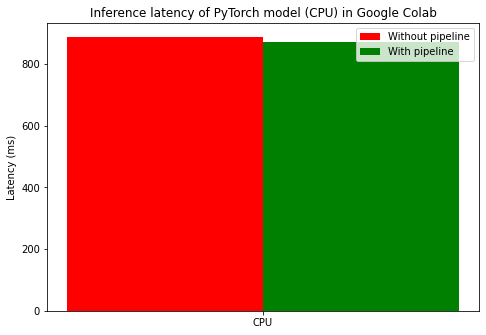

In [25]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['CPU']
data = [mean_time_cpu, pipeline_mean_time_cpu]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.arange(1)
ax.bar(X - 0.1, data[0], color = 'r', width = 0.2, label='Without pipeline')
ax.bar(X + 0.1, data[1], color = 'g', width = 0.2, label='With pipeline')

# axes and title
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference latency of PyTorch model (CPU) in Google Colab')

leg = ax.legend();

Pipeline does not help improve latency on CPU.

## 3. Inference time | ONNX Runtime

[ONNX Runtime](https://onnxruntime.ai/) helps **accelerate PyTorch and TensorFlow models in production, on CPU or GPU**. As an open source library built for performance and broad platform support, ONNX Runtime is used in products and services handling over 20 billion inferences each day. 

### 3.1 Old method | convert_graph_to_onnx.py

You can use ONNX Runtime and Hugging Face Transformers together to improve the experience of training and deploying NLP models. Hugging Face has made it easy to inference Transformer models with ONNX Runtime with the [transformers/convert_graph_to_onnx.py](https://github.com/huggingface/transformers/blob/master/src/transformers/convert_graph_to_onnx.py) which generates a model that can be loaded by ONNX Runtime.

In [26]:
!python -m transformers.onnx --help

usage: Hugging Face ONNX Exporter tool [-h] -m MODEL
                                       [--feature {causal-lm,causal-lm-with-past,default,default-with-past,masked-lm,seq2seq-lm,seq2seq-lm-with-past,sequence-classification,sequence-classification-with-past,token-classification}]
                                       [--opset OPSET] [--atol ATOL]
                                       output

positional arguments:
  output                Path indicating where to store generated ONNX model.

optional arguments:
  -h, --help            show this help message and exit
  -m MODEL, --model MODEL
                        Model's name of path on disk to load.
  --feature {causal-lm,causal-lm-with-past,default,default-with-past,masked-lm,seq2seq-lm,seq2seq-lm-with-past,sequence-classification,sequence-classification-with-past,token-classification}
                        Export the model with some additional feature.
  --opset OPSET         ONNX opset version to export the model with (defaul

````
SUPPORTED_PIPELINES = [
    "feature-extraction",
    "ner",
    "sentiment-analysis",
    "fill-mask",
    "question-answering",
    "text-generation",
    "translation_en_to_fr",
    "translation_en_to_de",
    "translation_en_to_ro",
]
````

Get the file convert_graph_to_onnx.py

In [27]:
!wget https://raw.githubusercontent.com/huggingface/transformers/master/src/transformers/convert_graph_to_onnx.py

--2021-10-23 16:56:09--  https://raw.githubusercontent.com/huggingface/transformers/master/src/transformers/convert_graph_to_onnx.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18640 (18K) [text/plain]
Saving to: ‘convert_graph_to_onnx.py’

convert_graph_to_on 100%[===================>]  18.20K  --.-KB/s    in 0s      

2021-10-23 16:56:10 (43.5 MB/s) - ‘convert_graph_to_onnx.py’ saved [18640/18640]



### 3.1.1 Tokenize the inputs

In [28]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [29]:
num=100

total = 0
for i in range(num):
  start = perf_counter()
  # WARNING!!!!!!! return_tensors="np" and not return_tensors="pt"
  inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="np")
  diff = perf_counter() - start
  total += diff

onnx_mean_tokenizer = round((total/num)*1000,2)
print(f'average time: {onnx_mean_tokenizer} ms')

average time: 0.71 ms


### 3.1.2 Model on CPU

#### Installation

In [30]:
%%capture
# onnxruntime cpu
!pip install onnx
!pip install onnxruntime

In [31]:
import onnxruntime as ort
ort.get_device()

'CPU'

In [32]:
import onnxruntime
print("onnxruntime:",onnxruntime.__version__)

onnxruntime: 1.9.0


#### Convert the transformer model to its quantized onnx version

In [33]:
model_checkpoint_onnx = 'onnx_cpu/' + model_checkpoint.replace('/','-') + '.onnx'

!python convert_graph_to_onnx.py \
--pipeline question-answering \
--model {model_checkpoint} \
--tokenizer {model_checkpoint} \
--framework pt \
--opset 11 \
--check-loading \
--use-external-format \
--quantize \
{model_checkpoint_onnx}


====== Converting model to ONNX ======
ONNX opset version set to: 11
Loading pipeline (model: pierreguillou/bert-base-cased-squad-v1.1-portuguese, tokenizer: pierreguillou/bert-base-cased-squad-v1.1-portuguese)
Creating folder /content/onnx_cpu
Using framework PyTorch: 1.9.0+cu111
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input token_type_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Found output output_1 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
position_ids is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask', 'token_type_ids']

====== Optimizing ONNX model ======
2021-10-23 16:56:33.317869392 [W:onnxruntime:, inference_session.cc:1419 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTra

#### Import the onnx quantized version of the model

In [34]:
import onnxruntime as ort

# copy/paste the path to the file xxx.quantized.onnx
ort_session = ort.InferenceSession("/content/" + model_checkpoint_onnx)

#### Run the onnx model

In [35]:
num = 100

total = 0
for i in range(num):
  start = perf_counter()
  outputs = ort_session.run(None, dict(inputs))
  diff = perf_counter() - start
  total += diff

onnx_mean_time_cpu = round((total/num)*1000,2)
print(f'average time: {onnx_mean_time_cpu} ms')

average time: 711.5 ms


Now, we can evaluate the time to get the answer.

In [36]:
num = 100

total = 0
for i in range(num):
  start = perf_counter()
  # code source: https://huggingface.co/transformers/master/task_summary.html#extractive-question-answering

  answer_start_scores = outputs[0]
  answer_end_scores = outputs[1]

  # Get the most likely beginning of answer with the argmax of the score
  answer_start = np.argmax(answer_start_scores)
  # Get the most likely end of answer with the argmax of the score
  answer_end = np.argmax(answer_end_scores) + 1

  input_ids = inputs["input_ids"].tolist()[0]
  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

  diff = perf_counter() - start
  total += diff
  
  # print(f"Question: {question}")
  # print(f"Answer: {answer}")

onnx_mean_time_cpu_answer = round((total/num)*1000,2)
print(f'average time: {onnx_mean_time_cpu_answer} ms')

average time: 0.07 ms


In [37]:
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: Quando começou a pandemia de Covid-19 no mundo?
Answer: 1 de dezembro de 2019


Then, we have the total time when the model is on the CPU:

In [38]:
onnx_total_cpu = round(onnx_mean_tokenizer + onnx_mean_time_cpu + onnx_mean_time_cpu_answer,2)
print(f'time: {onnx_total_cpu} ms')

time: 712.28 ms


### 3.1.4 Results with ONNX Runtime

In [39]:
import pandas as pd

raw_data = {
            'Latency on CPU (ms)': [mean_time_cpu, onnx_mean_time_cpu],
            }

df = pd.DataFrame(raw_data,
                  index=pd.Index(['PyTorch (without pipeline)', 'ONNX Runtime']),
                  columns=pd.Index(['Latency on CPU (ms)']))

df

,Latency on CPU (ms)
PyTorch (without pipeline),889.07
ONNX Runtime,711.50


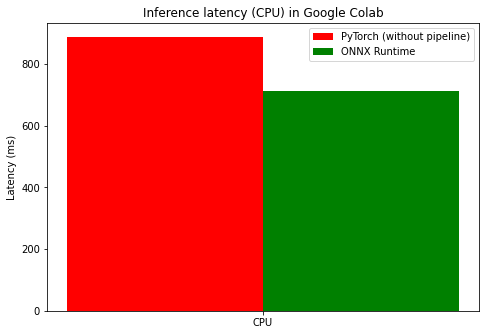

In [40]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['CPU']
data = [mean_time_cpu, onnx_mean_time_cpu]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.arange(1)
ax.bar(X - 0.1, data[0], color = 'r', width = 0.2, label='PyTorch (without pipeline)')
ax.bar(X + 0.1, data[1], color = 'g', width = 0.2, label='ONNX Runtime')

# axes and title
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference latency (CPU) in Google Colab')

leg = ax.legend();

- ONNX Runtime helps improve latency on CPU (just a bit).
- On CPU, using **ONNX Runtime** allows inferring up to **1.2 times faster** than with the PyTorch model (**632.58 ms** with ONNX Runtime).

### 3.2 New method | transformers.onnx

(source: [Configuration-based approach](https://huggingface.co/transformers/master/serialization.html#configuration-based-approach)) Transformers v4.9.0 introduces a new package: `transformers.onnx`. **This package allows converting checkpoints to an ONNX graph by leveraging configuration objects.** These configuration objects come ready made for a number of model architectures, and are made to be easily extendable to other architectures.

Ready-made configurations include the following models:

````
ALBERT
BART
BERT
DistilBERT
GPT Neo
LayoutLM
Longformer
mBART
OpenAI GPT-2
RoBERTa
T5
XLM-RoBERTa
````

Run `transformers.onnx` (or the conversion script located at [transformers/convert_graph_to_onnx.py](https://github.com/huggingface/transformers/blob/master/src/transformers/convert_graph_to_onnx.py)). This script takes a few arguments such as the model to be exported and the framework you want to export from (PyTorch or TensorFlow).

**WARNING**: which arguments to use?

It will be exported under `onnx/pierreguillou-bert-base-cased-squad-v1.1-portuguese`.

In [41]:
%%time
model_checkpoint_onnx = 'onnx/' + model_checkpoint.replace('/','-')

!python -m transformers.onnx --model {model_checkpoint} {model_checkpoint_onnx}

Some weights of the model checkpoint at pierreguillou/bert-base-cased-squad-v1.1-portuguese were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at pierreguillou/bert-base-cased-squad-v1.1-portuguese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using framework PyTorch: 1.9.0+cu111
Overriding 1 

The outputs can be obtained by taking a look at the ONNX configuration of each model. For example, for BERT:

In [42]:
from transformers.models.bert import BertOnnxConfig, BertConfig

config = BertConfig()
onnx_config = BertOnnxConfig(config)
output_keys = list(onnx_config.outputs.keys())
output_keys

['last_hidden_state', 'pooler_output']

**WARNING**: these outputs do not allow to get an answer!!!!!

We can not continue. 

In [43]:
# import onnxruntime as ort
# ort_session = ort.InferenceSession('onnx/pierreguillou-bert-base-cased-squad-v1.1-portuguese/model.onnx')

## 4. Inference time | TorchScript

source: https://huggingface.co/transformers/serialization.html#torchscript

According to Pytorch’s documentation: “TorchScript is a way to create serializable and optimizable models from PyTorch code”. Pytorch’s two modules JIT and TRACE allow the developer to export their model to be re-used in other programs, such as efficiency-oriented C++ programs.

Hugging Face provided an interface that allows the export of 🤗 Transformers models to TorchScript so that they can be reused in a different environment than a Pytorch-based python program. 

In [44]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, torchscript=True)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint, torchscript=True)
model.eval();

In [45]:
model.bert.embeddings.word_embeddings.weight.data[0][0].item()

0.009311608970165253

In [46]:
import sys
sys.getsizeof(model.bert.embeddings.word_embeddings.weight.data[0][0].item()) 

24

### 4.1 Tokenize the inputs

In [47]:
num=100

total = 0
for i in range(num):
  start = perf_counter()
  inputs = tokenizer(question, context, add_special_tokens=True, return_tensors="pt")
  diff = perf_counter() - start
  total += diff

torchscript_mean_tokenizer = round((total/num)*1000,2)
print(f'average time: {torchscript_mean_tokenizer} ms')

average time: 0.82 ms


### 4.2 Model on CPU

In [48]:
# put model and inputs to cpu
model = model.to('cpu')
inputs = inputs.to('cpu')

# get mean time
with torch.no_grad():
  traced_model = torch.jit.trace(model, [inputs.input_ids,inputs.token_type_ids,inputs.attention_mask])
  torchscript_mean_time_cpu = round(np.mean([timer(traced_model,inputs.input_ids,inputs.token_type_ids,inputs.attention_mask) for _ in range(100)]))
print(f'{torchscript_mean_time_cpu}ms')

849ms


### 4.3 Results with TorchScript

In [49]:
import pandas as pd

raw_data = {
            'Latency on CPU (ms)': [mean_time_cpu, onnx_mean_time_cpu, torchscript_mean_time_cpu],
            }

df = pd.DataFrame(raw_data,
                  index=pd.Index(['PyTorch (without pipeline)', 'ONNX Runtime', 'TorchScript']),
                  columns=pd.Index(['Latency on CPU (ms)']))

df

,Latency on CPU (ms)
PyTorch (without pipeline),889.07
ONNX Runtime,711.50
TorchScript,849.00


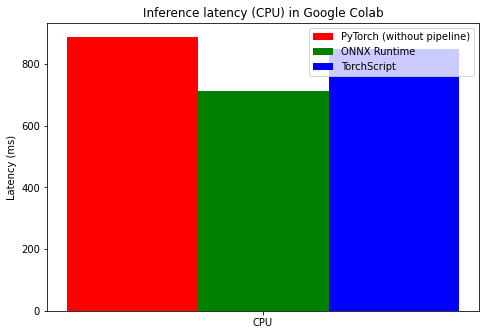

In [50]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['CPU']
data = [mean_time_cpu, onnx_mean_time_cpu, torchscript_mean_time_cpu]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.arange(1)
ax.bar(X - 0.2, data[0], color = 'r', width = 0.2, label='PyTorch (without pipeline)')
ax.bar(X, data[1], color = 'g', width = 0.2, label='ONNX Runtime')
ax.bar(X + 0.2, data[2], color = 'b', width = 0.2, label='TorchScript')

# axes and title
x = np.arange(len(labels))  # the label locations
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference latency (CPU) in Google Colab')

leg = ax.legend();

- TorchScript does not help improve latency on CPU.
- On CPU, it's better to use **ONNX Runtime**.

# END